In [3]:
import pandas as pd
import numpy as num
import statsmodels.api as sm
from datetime import timedelta

C:\Users\Carlos Bonilla\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [16]:
#Upload csv and excel datasets
Savefolder = "C:\\Users\\Carlos Bonilla\\Google Drive\\Wharton\\Clubs\\Wharton Analytic Fellows\\"
Fitting_Data_All=pd.read_excel(Savefolder+"Fittting Data (World Bank Global Economic Indicators) v4.xlsx", sheet_name="Data")
ECRCountriesFitted = pd.read_excel(Savefolder+"ECRCountriesFitted.xlsx", sheet_name=None)

In [6]:
#Prepare ECR General score data for analysis
ECR=pd.read_excel(Savefolder+"ECR Testing Data.xlsx", sheet_name='ECR_SubScores')

#ECR.groupby(pd.TimeGrouper(freq='M'),'country').mean()
#ECR.groupby('country',pd.TimeGrouper(freq='M')).mean()
ECRA = ECR.pivot(index='date', columns='country', values='General_Score')
ECRA = ECRA.resample('M').mean()
ECRA['date'] = pd.to_datetime(ECRA.index)

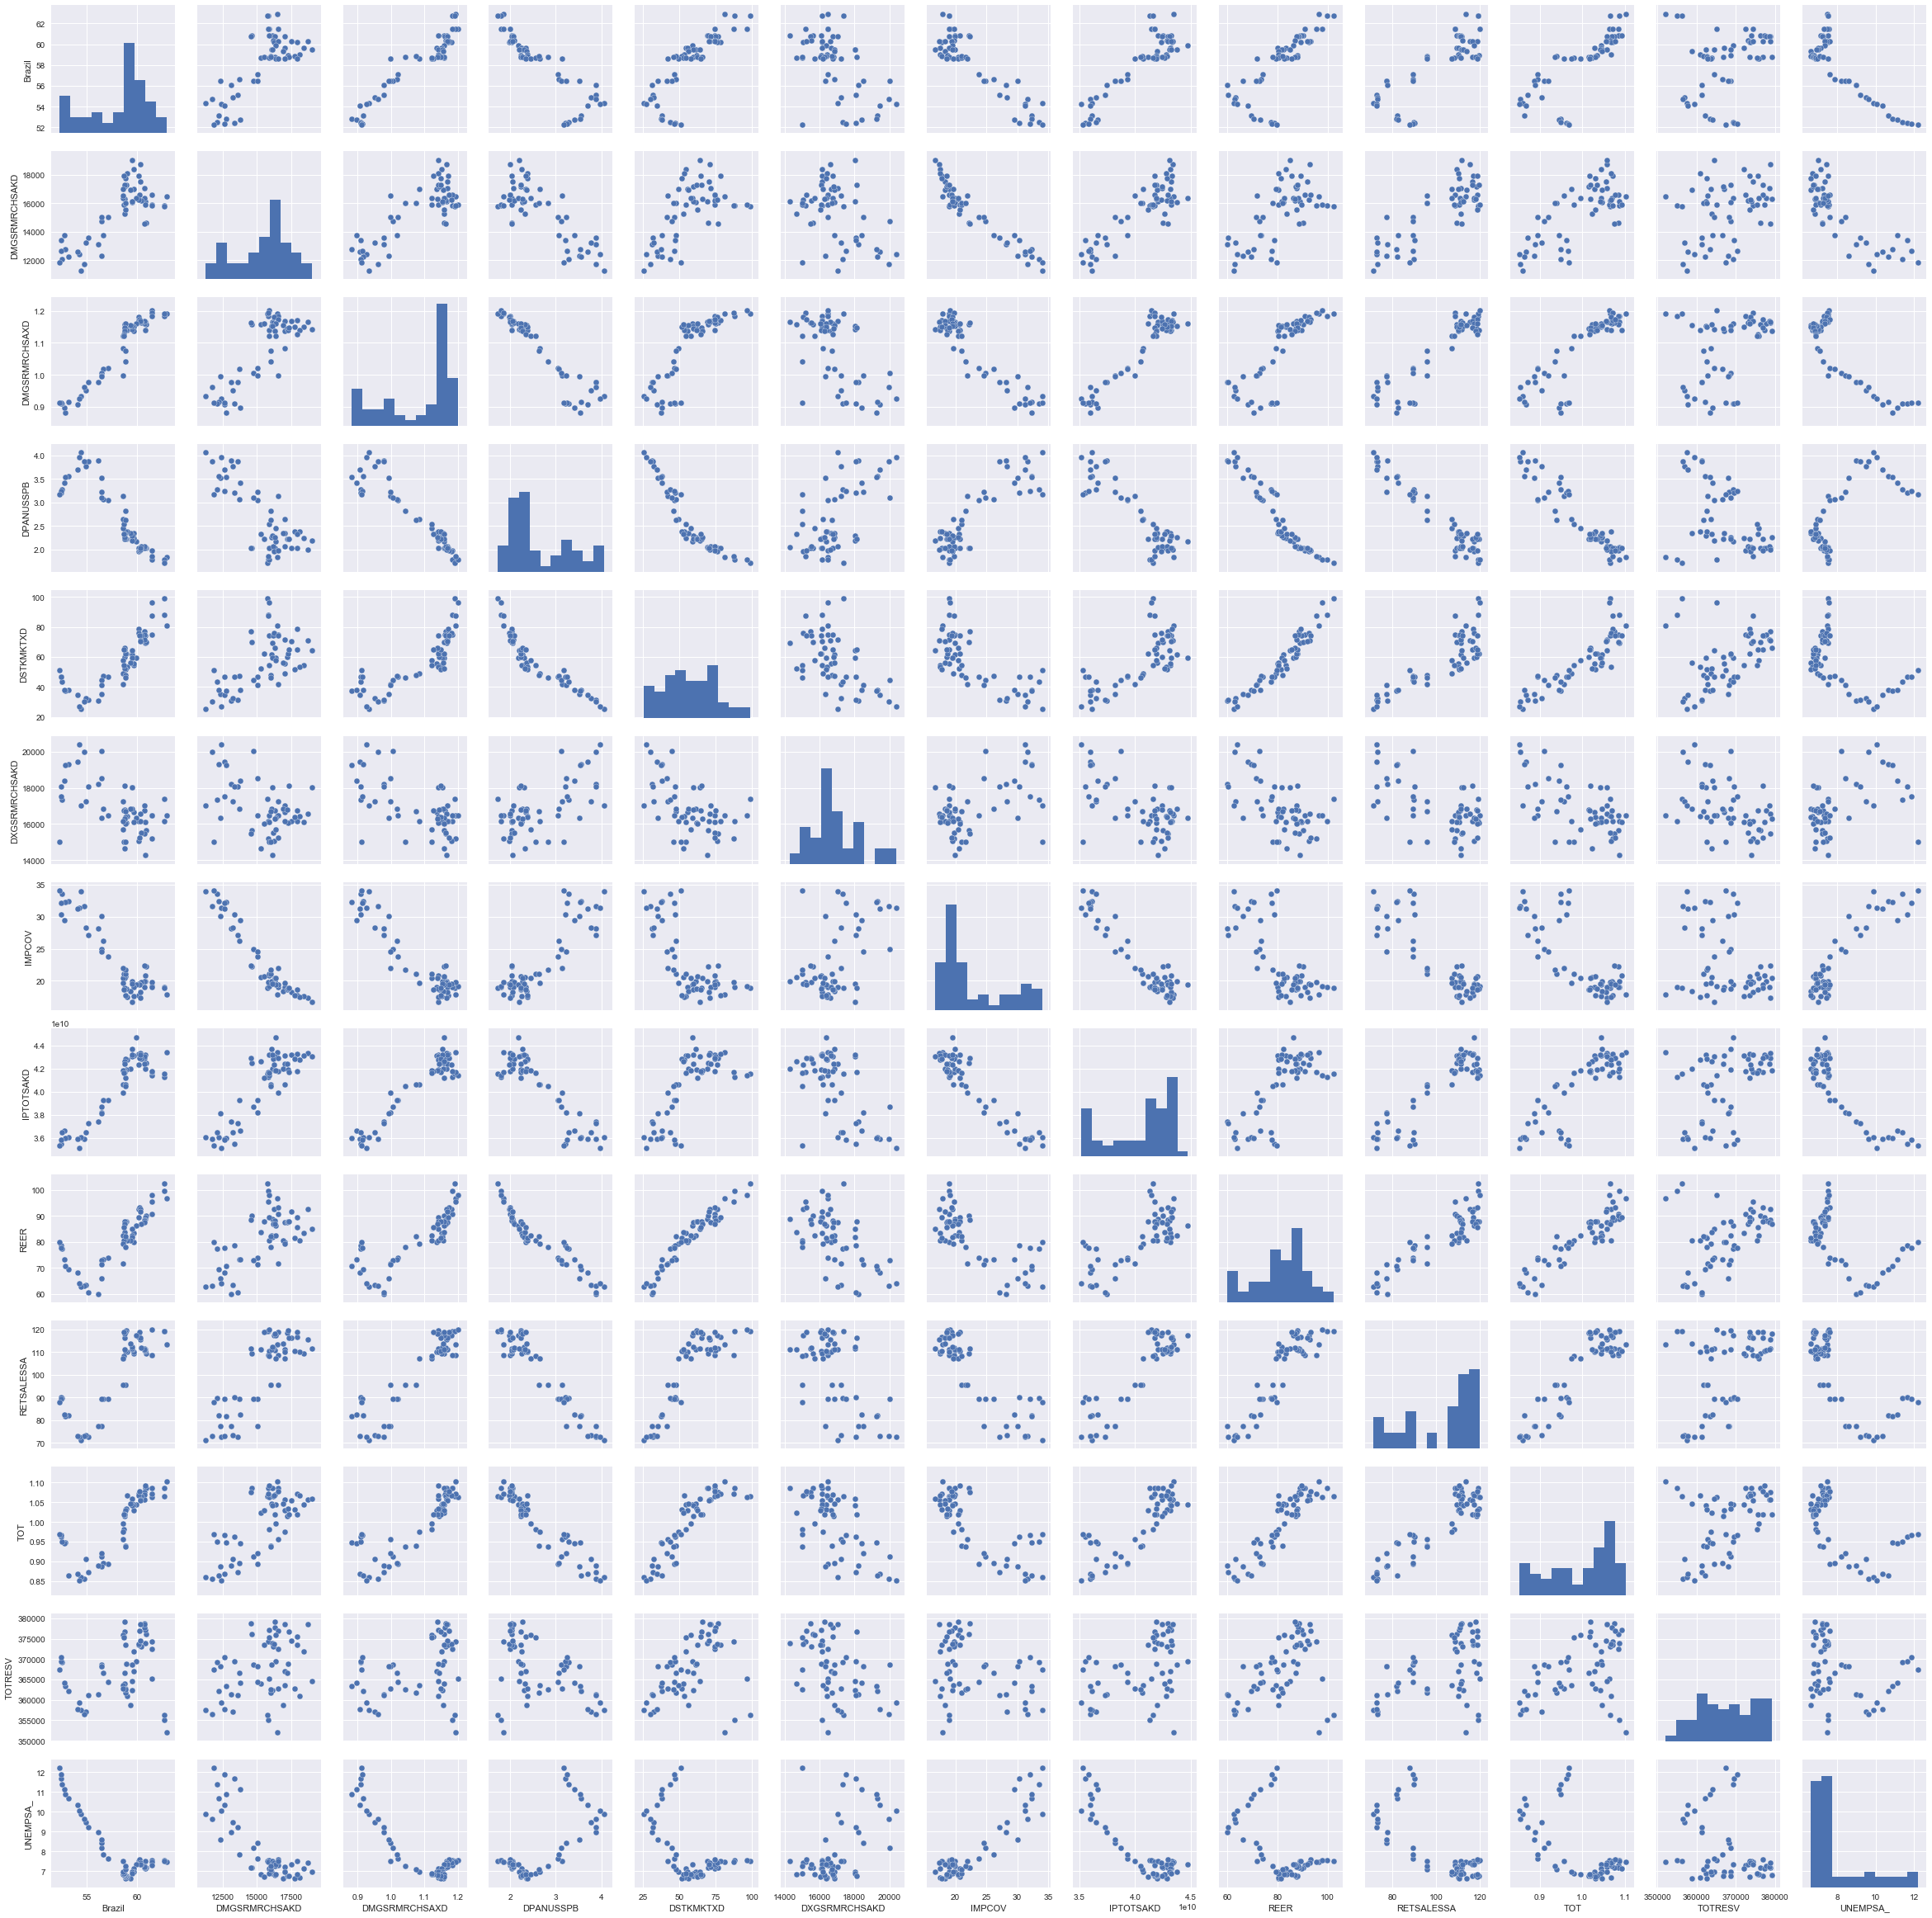

In [105]:
#Chart for identifying highly correlated variables
import seaborn as sns

tempDf = Fitting_Data_All.loc[Fitting_Data_All['Country'] == 'Brazil']
del tempDf['Country Code']
del tempDf['Series']
del tempDf['Country']
tempDf = pd.melt(tempDf, id_vars=["Series Code"],var_name="date")
tempDf = tempDf.pivot(index='date', columns='Series Code', values='value')
tempDf['date'] = tempDf.index
tempDf = pd.merge(ECRA[['Brazil','date']],tempDf, how='left', on='date',left_index=False, 
                  right_index=False, sort=False, copy=True, indicator=False)
tempDf = tempDf.dropna(axis=1, how='any')
#subDf = tempDf[0:28]
#del subDf['REER']
#del subDf['DPANUSSPB']
#del subDf['IMPCOV']

#subDf
sns.pairplot(tempDf)
sns.plt.show()

In [203]:
#Segmented regression looping model
#this model fits a linear regression in 20 period increments
#the columns deleted from the subDf either added multicollinearity or had NaNs

import statsmodels.api as sm

CountryDict = {}

for theCountry in ECRCountriesFitted['Country'].unique():
    try:
        print(theCountry)
        tempDf = Fitting_Data_All.loc[Fitting_Data_All['Country'] == theCountry]
        del tempDf['Country Code']
        del tempDf['Series']
        del tempDf['Country']
        tempDf = pd.melt(tempDf, id_vars=["Series Code"],var_name="date")
        tempDf = tempDf.pivot(index='date', columns='Series Code', values='value')
        tempDf['date'] = tempDf.index
        tempDf = pd.merge(ECRA[[theCountry,'date']],tempDf, how='left', on='date',left_index=False, 
                          right_index=False, sort=False, copy=True, indicator=False)
        del tempDf['REER']
        del tempDf['DPANUSSPB']
        del tempDf['IMPCOV']
        del tempDf['DSTKMKTXD']
        del tempDf['RETSALESSA']
        del tempDf['IPTOTSAKD']
        #del tempDf['UNEMPSA_']
        tempDf = tempDf.dropna(axis=1, how='any')
        subDf = tempDf[0:30]
        subDf1 = tempDf[31:60]
        ols_fits = [sm.OLS(subDf[theCountry],subDf.iloc[:,3:20]).fit(),
                    sm.OLS(subDf1[theCountry],subDf1.iloc[:,3:20]).fit()]
        ols_predictions = [ols_fits[0].predict(tempDf.iloc[:,3:20]),ols_fits[1].predict(tempDf.iloc[:,3:20])]
        result = [ols_fits,ols_predictions]
    except ValueError:
        pass     
    CountryDict[theCountry] = result

Brazil
Bulgaria
Chile
Czech Republic
Egypt
Hungary
India
Indonesia
Israel
Korea South
Malaysia
Mexico
Peru
Philippines
Poland
Romania
Russia
South Africa
Thailand
Turkey


In [217]:
#Segmented regression looping model
#this model fits a linear regression in 20 period increments
#the columns deleted from the subDf either added multicollinearity or had NaNs

CountryPredictions = {}

for theCountry in ECRCountriesFitted['Country'].unique():
    try:
        df = pd.DataFrame.from_records(CountryDict[theCountry][1])
        df = df.transpose()
        
        temp = ECRA[theCountry].reset_index()
        df[theCountry] = temp[theCountry]
    except ValueError:
        pass     
    CountryPredictions[theCountry] = df

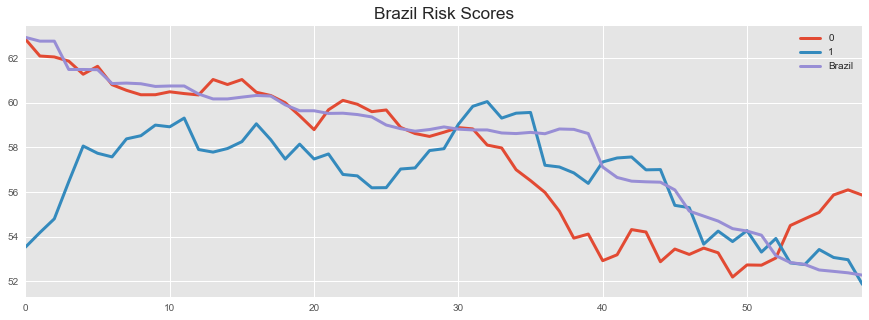

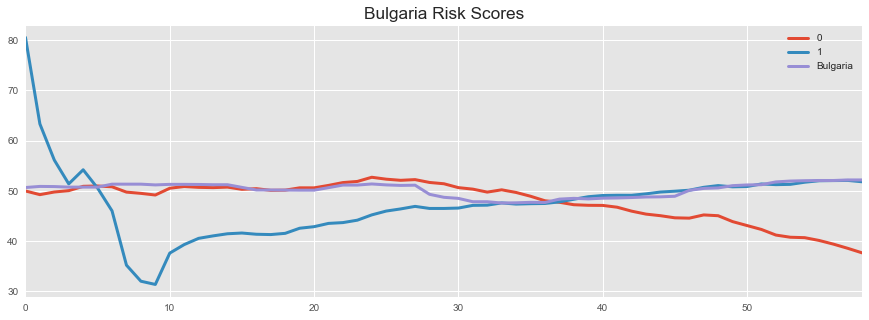

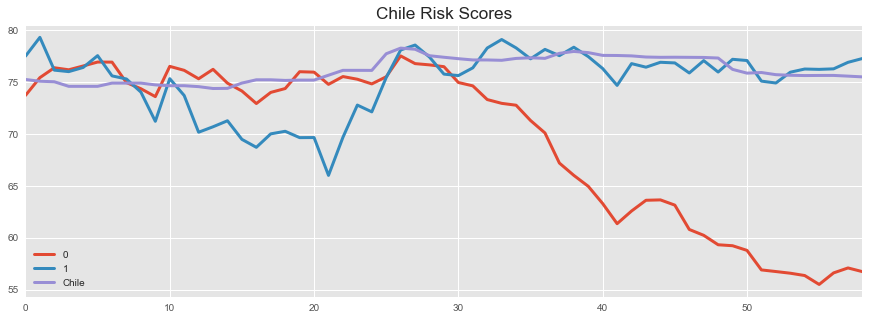

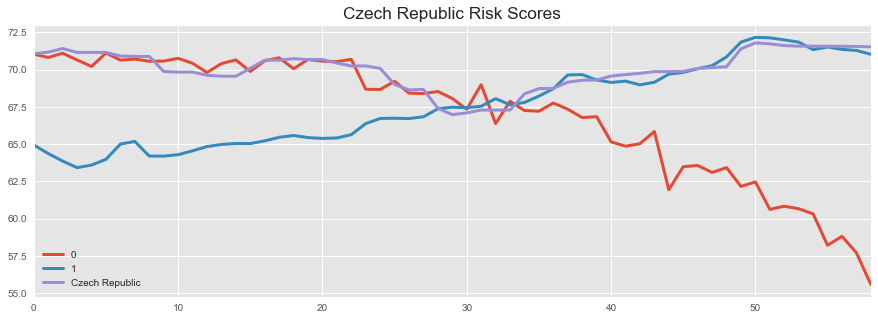

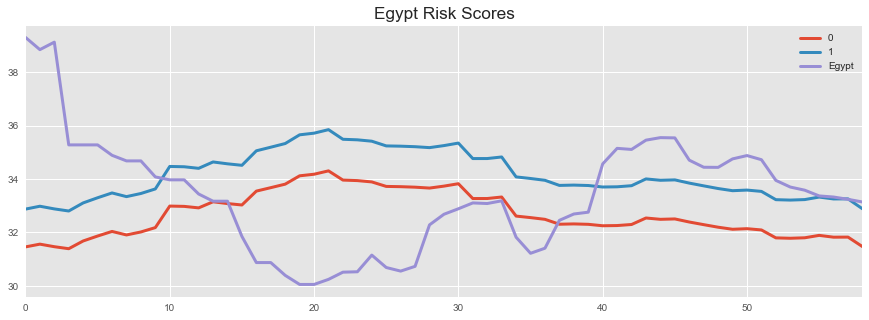

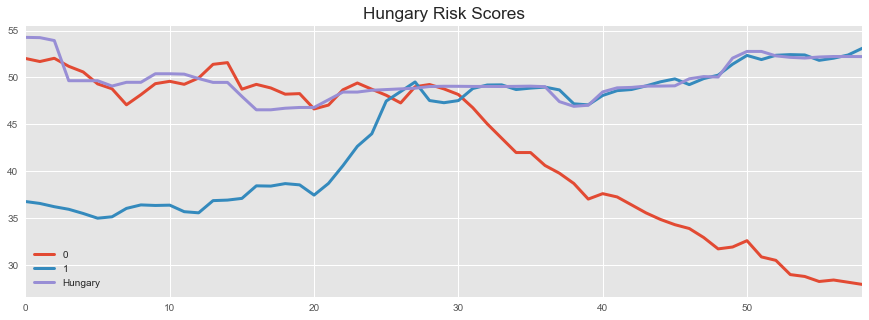

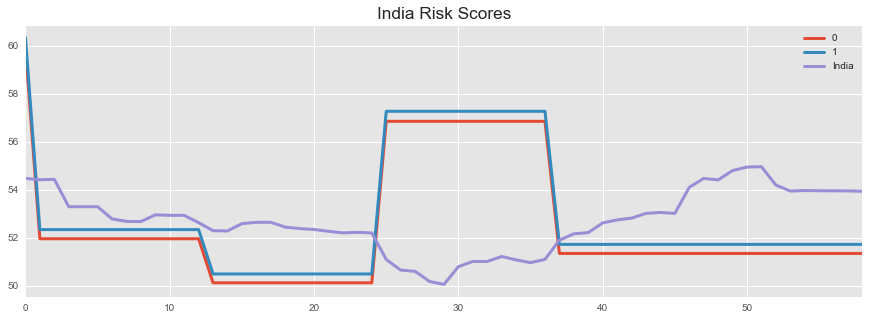

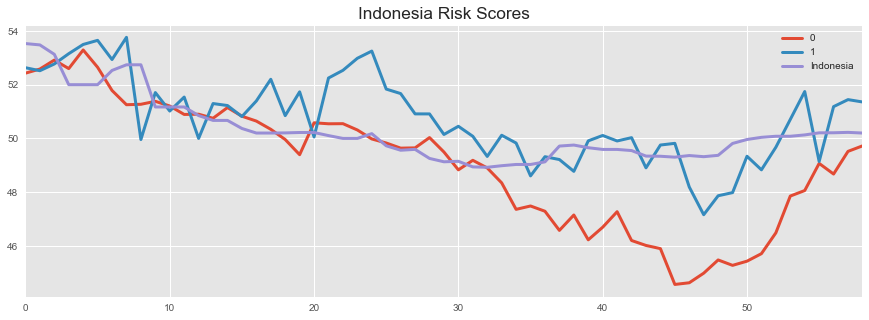

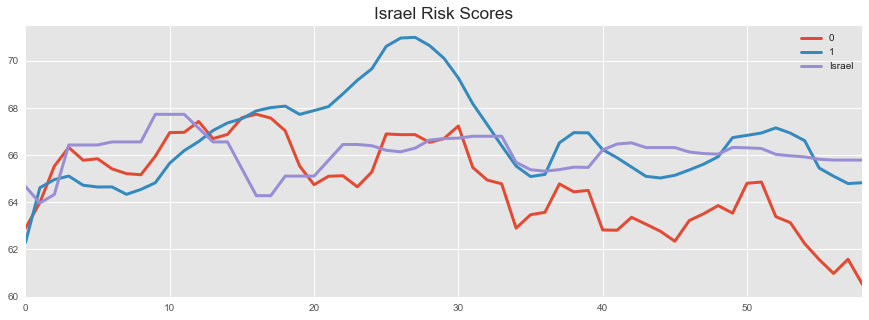

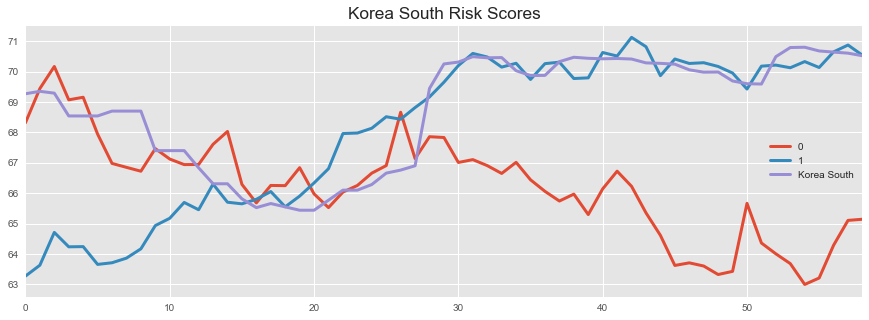

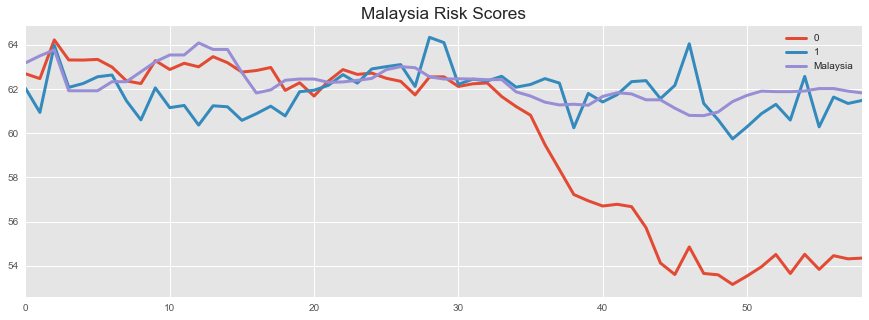

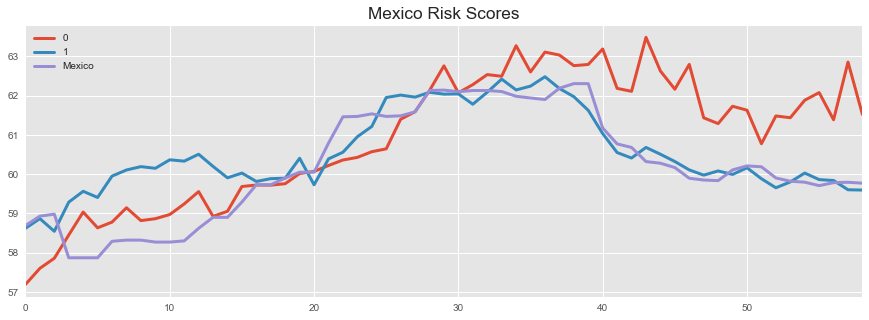

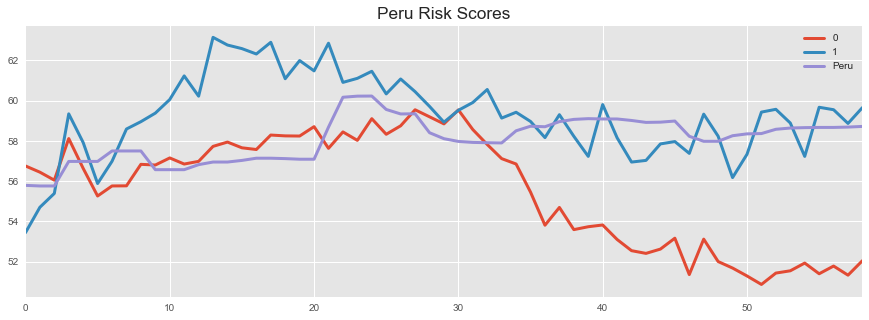

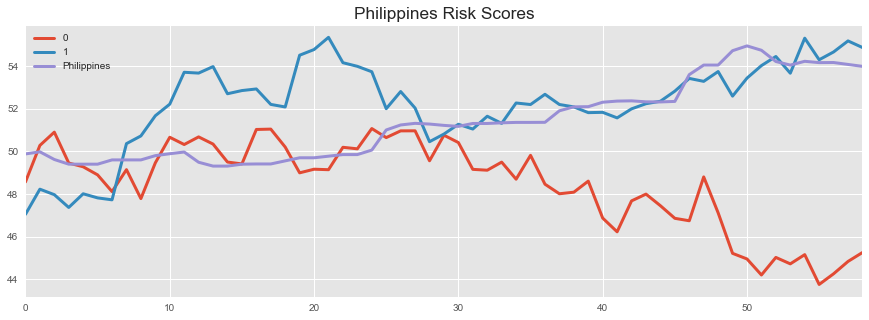

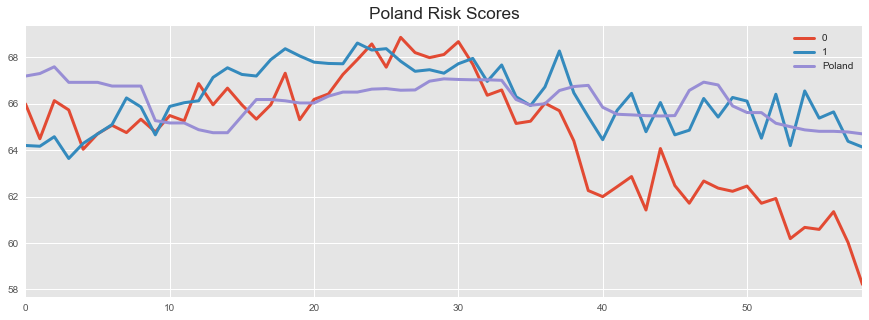

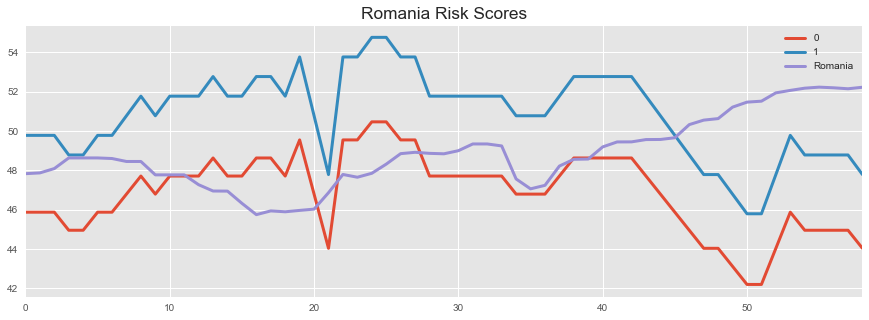

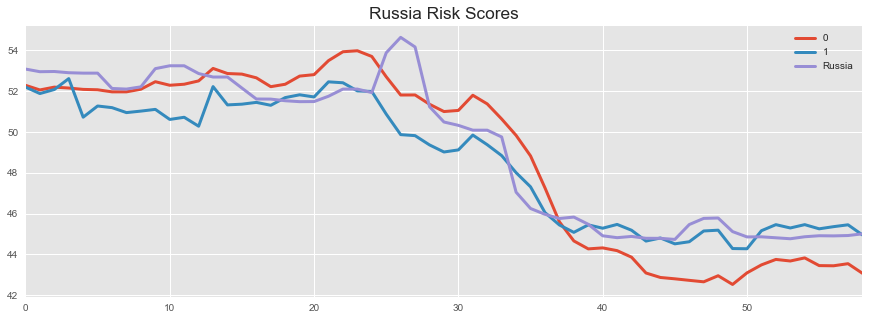

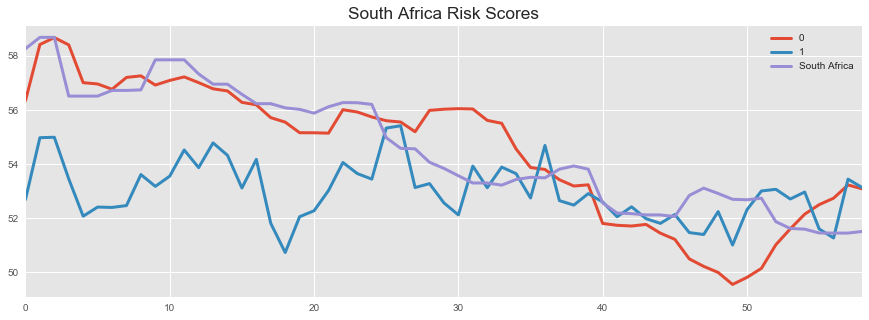

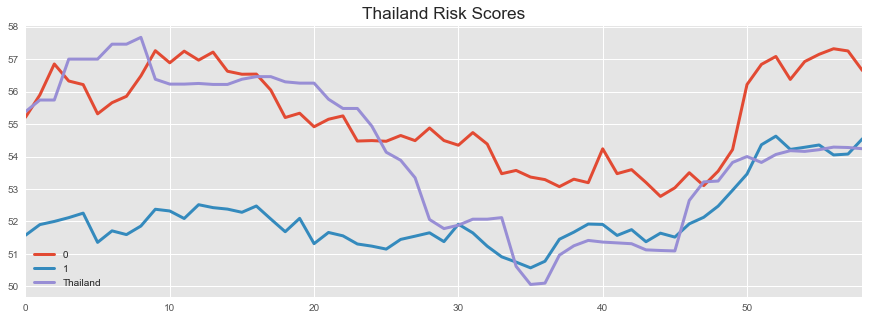

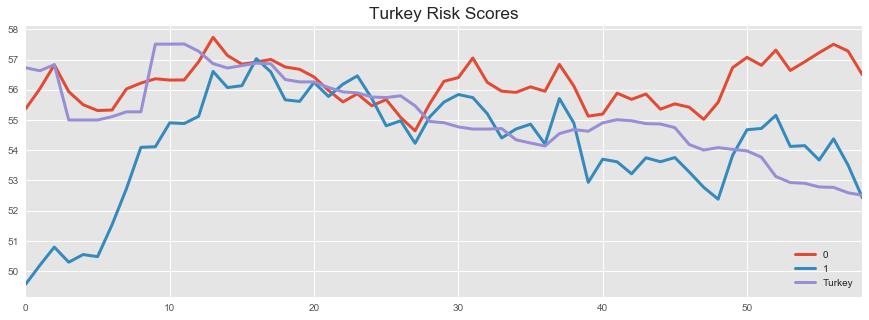

In [222]:
# Create time series of the sub risk factors for each country and plot
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
pd.set_option('precision', 2)
plt.rcParams['lines.linewidth'] = 3

for theCountry in ECRCountriesFitted['Country'].unique():
    try:
        CountryPredictions[theCountry].plot(subplots = False, figsize=(15,5))
        plt.title(theCountry+' Risk Scores')
        plt.show()
    except TypeError:
        pass

References:

http://marcharper.codes/2016-06-14/Linear+Regression+with+Statsmodels+and+Scikit-Learn.html

Sherouse, Oliver (2014). Wbdata. Arlington, VA. Available from http://github.com/OliverSherouse/wbdata

https://blogs.worldbank.org/opendata/accessing-world-bank-data-apis-python-r-ruby-stata

http://www.bd-econ.com/index.html

